<a href="https://colab.research.google.com/github/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/blob/main/02_Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Partición de dataset
from sklearn.model_selection import train_test_split

# Particion de entrenamiento KFol y tunning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV

# Librerias de modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Librerias para reporte de metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef, make_scorer

# **Carga y ajustes del dataset**

In [ ]:
# Carga desde github
url = "https://raw.githubusercontent.com/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/main/Dataset/StudentPerformanceFactors.csv"
df = pd.read_csv(url)

In [ ]:
# Limpieza de nulos y valores fuera del margen
df = df.dropna()
df = df[df['Exam_Score'] <= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6377 non-null   int64 
 1   Attendance                  6377 non-null   int64 
 2   Parental_Involvement        6377 non-null   object
 3   Access_to_Resources         6377 non-null   object
 4   Extracurricular_Activities  6377 non-null   object
 5   Sleep_Hours                 6377 non-null   int64 
 6   Previous_Scores             6377 non-null   int64 
 7   Motivation_Level            6377 non-null   object
 8   Internet_Access             6377 non-null   object
 9   Tutoring_Sessions           6377 non-null   int64 
 10  Family_Income               6377 non-null   object
 11  Teacher_Quality             6377 non-null   object
 12  School_Type                 6377 non-null   object
 13  Peer_Influence              6377 non-null   object
 1

In [ ]:
# Hay 13 variables de tipo categoricas, se convierten en tipo numericas (se le da un valor ya sea 0 y 1, o 1,2,3)

df_encoded = df.copy()

# Categorizacion binaria para categorias que son solo 2 dos tipos

# get_dummies - Convierte tablas categoricas en binarios
# drop_first - quita la columna redudante que se genera
df_encoded = pd.get_dummies(df_encoded, columns=["Extracurricular_Activities", "Internet_Access", "School_Type", "Learning_Disabilities", "Gender"], drop_first=True)

# Categorizacion por categorias que son de 3 tipos

# para categorias bajo - medio - alto
mapping = {"Low":1, "Medium":2, "High":3}
columnas = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Family_Income", "Teacher_Quality"]

for columna in columnas:
    df_encoded[columna] = df_encoded[columna].map(mapping)

# para categoria negativo - positivo - neutral
mapping = {"Negative":-1, "Positive":1, "Neutral":0}
df_encoded["Peer_Influence"] = df_encoded["Peer_Influence"].map(mapping)

# para categoria High School - College - Postgraduate
mapping = {"High School":1, "College":2, "Postgraduate":3}
df_encoded["Parental_Education_Level"] = df_encoded["Parental_Education_Level"].map(mapping)

# para categoria Near - Moderate - Far
mapping = {"Near":1, "Moderate":2, "Far":3}
df_encoded["Distance_from_Home"] = df_encoded["Distance_from_Home"].map(mapping)


# Convertir las columnas booleanas resultantes en 0 y 1
bool_cols = df_encoded.select_dtypes(include=["bool"]).columns # Se seleccionan las columnas solamente las columnas booleanas
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int) # Se convierten en 0 y 1

In [ ]:
df_encoded

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Exam_Score,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,23,84,1,3,7,73,1,0,1,2,1,3,1,1,67,0,1,1,0,1
1,19,64,1,2,8,59,1,2,2,2,-1,4,2,2,61,0,1,1,0,0
2,24,98,2,2,7,91,2,2,2,2,0,4,3,1,74,1,1,1,0,1
3,29,89,1,2,8,98,2,1,2,2,-1,4,1,2,71,1,1,1,0,1
4,19,92,2,2,6,65,2,3,2,3,0,4,2,1,70,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,3,2,7,76,2,1,3,2,1,2,1,1,68,0,1,1,0,0
6603,23,76,3,2,8,81,2,3,1,3,1,2,1,1,69,0,1,1,0,0
6604,20,90,2,1,6,65,1,3,1,2,-1,2,3,1,68,1,1,1,0,0
6605,10,86,3,3,6,91,3,2,1,2,1,3,1,3,68,1,1,0,0,0


# **Umbral de aprobados por puntaje mayor igual a *60***


---



In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 60
df_60['Aprobados'] = df_60['Exam_Score'] >= 60

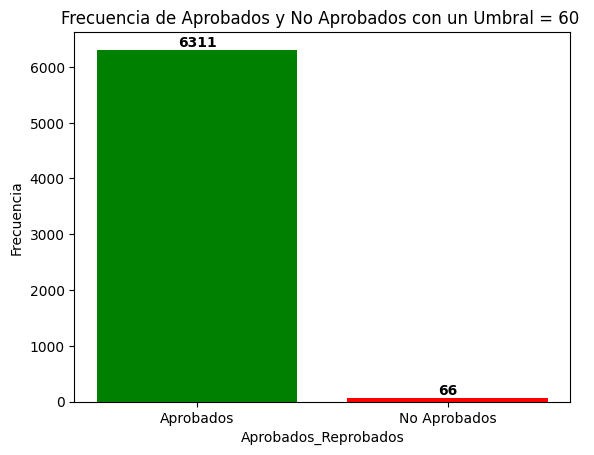

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 60 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

In [ ]:
############################### COMENTAR #######################################

In [ ]:
############################### COMENTAR #######################################

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento
X = df_60.drop(['Exam_Score','Aprobados'], axis=1)
y = df_60['Aprobados']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
############################### COMENTAR #######################################

## **Gaussian Bayes**

In [ ]:
# Modelo base
model = GaussianNB()

# Validación cruzada con StratifiedKFold SOLO CON ENTRENAMIENTOS
# Con 5 splits de organizacion
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Obtencion de los resultados de la validación cruzada con metricas puntuales
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_estimator=True
)

In [ ]:
# Se obtienen los modelos entrenados
estimadores = cv_results['estimator']

In [ ]:
# Se evalua cada modelo con el conjunto X_test, y_test

# Listas para almacenar métricas
balanced_accs = []
mccs = []

for i, est in enumerate(estimadores, start=1):

    # Predición con X_test a partir del modelo entrenado del kfold
    y_pred = est.predict(X_test)

    # Reporte de clasificación detallado
    print(f"\nReporte de clasificación kfold {i}:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Metricas de desbalance
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.3f}")
    print(f"Matthews CorrCoef: {mcc:.3f}")

    # Guardamos las métricas
    balanced_accs.append(balanced_acc)
    mccs.append(mcc)

    print("-" * 60)


Reporte de clasificación kfold 1:
              precision    recall  f1-score   support

       False       0.67      0.46      0.55        13
        True       0.99      1.00      1.00      1263

    accuracy                           0.99      1276
   macro avg       0.83      0.73      0.77      1276
weighted avg       0.99      0.99      0.99      1276

Balanced Accuracy: 0.730
Matthews CorrCoef: 0.551
------------------------------------------------------------

Reporte de clasificación kfold 2:
              precision    recall  f1-score   support

       False       0.71      0.38      0.50        13
        True       0.99      1.00      1.00      1263

    accuracy                           0.99      1276
   macro avg       0.85      0.69      0.75      1276
weighted avg       0.99      0.99      0.99      1276

Balanced Accuracy: 0.692
Matthews CorrCoef: 0.521
------------------------------------------------------------

Reporte de clasificación kfold 3:
              preci

In [ ]:
# Promedios finales
print("\n===== PROMEDIO GLOBAL ENTRE KFOLDS =====")
print(f"Balanced Accuracy promedio: {np.mean(balanced_accs):.3f}")
print(f"Matthews CorrCoef promedio: {np.mean(mccs):.3f}")
print("=========================================")


===== PROMEDIO GLOBAL ENTRE KFOLDS =====
Balanced Accuracy promedio: 0.730
Matthews CorrCoef promedio: 0.572


## **Decision Tree**

In [ ]:
# Modelo base
tree = DecisionTreeClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, None]
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tuning con grid_search
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2
)

In [ ]:
############################### COMENTAR #######################################

In [ ]:
# Entrenamiento del GridSearch
grid_search.fit(X_train, y_train)

# Resultados
print("\n Mejor parámetro encontrado:")
print(grid_search.best_params_)

print("\n Balanced Accuracy promedio (validación cruzada):")
print(grid_search.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits

 Mejor parámetro encontrado:
{'max_depth': 20}

 Balanced Accuracy promedio (validación cruzada):
0.733923018664602


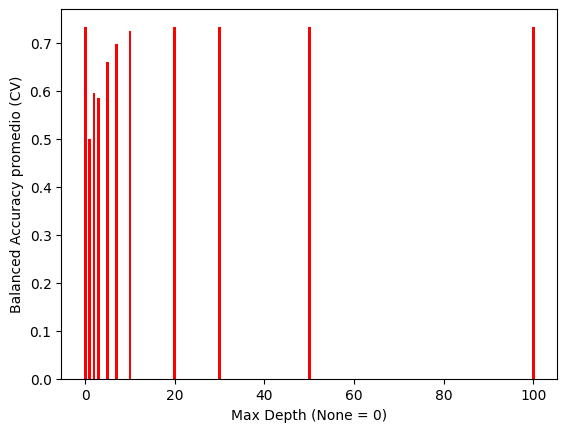

In [ ]:
# Gráfica
results = grid_search.cv_results_
depths = [d if d is not None else 0 for d in param_grid['max_depth']]
scores = results['mean_test_score']

plt.bar(depths, scores, color='red', width= 0.6)
plt.xlabel('Max Depth (None = 0)')
plt.ylabel('Balanced Accuracy promedio (CV)')
plt.show()

In [ ]:
# Obtención de los mejores parametros (Aunque en este caso es solo uno)
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 20}


In [ ]:
best_tree = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    random_state=42
)

In [ ]:
# Obtencion de los resultados de la validación cruzada con metricas puntuales
cv_results2 = cross_validate(
    best_tree,
    X_train,
    y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_estimator=True
)

In [ ]:
# Se obtienen los modelos entrenados
estimadores = cv_results2['estimator']

In [ ]:
# Se evalua cada model con el conjunto X_test, y_test

# Listas para almacenar métricas
balanced_accs = []
mccs = []

for i, est in enumerate(estimadores, start=1):

    # Predición con X_test a partir del modelo entrenado del kfold
    y_pred = est.predict(X_test)

    # Reporte de clasificación detallado
    print(f"\nReporte de clasificación kfold {i}:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Metricas de desbalance
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.3f}")
    print(f"Matthews CorrCoef: {mcc:.3f}")

    # Guardamos las métricas
    balanced_accs.append(balanced_acc)
    mccs.append(mcc)

    print("-" * 60)


Reporte de clasificación kfold 1:
              precision    recall  f1-score   support

       False       0.25      0.38      0.30        13
        True       0.99      0.99      0.99      1263

    accuracy                           0.98      1276
   macro avg       0.62      0.69      0.65      1276
weighted avg       0.99      0.98      0.98      1276

Balanced Accuracy: 0.686
Matthews CorrCoef: 0.301
------------------------------------------------------------

Reporte de clasificación kfold 2:
              precision    recall  f1-score   support

       False       0.15      0.15      0.15        13
        True       0.99      0.99      0.99      1263

    accuracy                           0.98      1276
   macro avg       0.57      0.57      0.57      1276
weighted avg       0.98      0.98      0.98      1276

Balanced Accuracy: 0.573
Matthews CorrCoef: 0.145
------------------------------------------------------------

Reporte de clasificación kfold 3:
              preci

In [ ]:
# Evaluación final en el conjunto de prueba
#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)
#final_score = balanced_accuracy_score(y_test, y_pred)
#print(f"\n Balanced Accuracy en test: {final_score:.3f}\n\n")

In [ ]:
# Resultados detallados por fold
#cv_results = pd.DataFrame(grid_search.cv_results_)

# Identificar el índice del mejor modelo
#best_idx = grid_search.best_index_

# Columnas de los 5 folds
#split_cols = [col for col in cv_results.columns if col.startswith("split") and "test_score" in col]

#print("\n Balanced Accuracy por fold (solo mejor modelo):\n")

#for j, col in enumerate(split_cols, start=1):
#    print(f"Fold {j}: {cv_results.loc[best_idx, col]:.4f}")

## **Random Forest**

## **Support Vector Machine**

# **Umbral de aprobados por puntaje mayor igual a *67***


---


In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 67

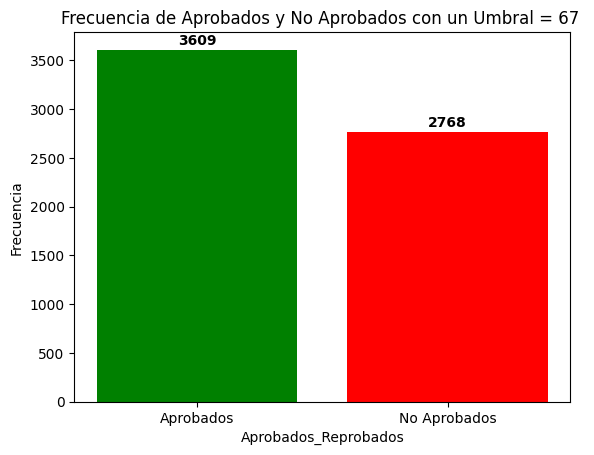

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 67 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

## **Gaussian Bayes**

## **Decision Tree**

## **Random Forest**

## **Support Vector Machine**

# **Umbral de aprobados por puntaje mayor igual a *70***

---

In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 70

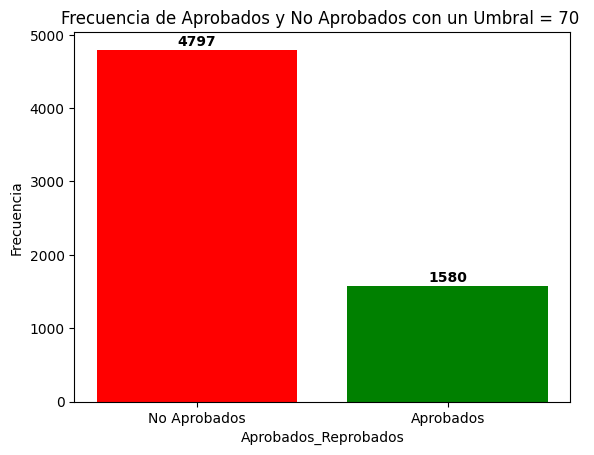

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 70 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

## **Gaussian Bayes**

## **Decision Tree**

## **Random Forest**

## **Support Vector Machine**